# Code for image benchmark baselines

## 1. Imports

In [1]:
import math
import gc
import wandb
import json
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn

from sklearn.decomposition import PCA

# from scipy.special import gamma
# from src.anime_benchmark import get_anime_benchmark
from eot_benchmark.image_benchmark import get_image_benchmark

from src.tools import load_dataset, get_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_fixed_images
from src.tools import fig2data, fig2img # for wandb

In [2]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [3]:
EPS = 0.1

GPU_DEVICE = 0
EPSILON = EPS

SEED = 42
MAX_STEPS = 1000
PLOT_INTERVAL = 500
CPKT_INTERVAL = 500
GRAY_PLOTS = False
FID_EPOCHS = 1
CONTINUE = -1

In [4]:
EXP_NAME = f'Image_identity_baseline_EPSILON_{EPSILON}'

config = dict(
    EPSILON=EPSILON,
    SEED=SEED,
    MAX_STEPS=MAX_STEPS,
)

In [5]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

In [7]:
filename = f"../stats/Image_Y_test_eps_{EPS}.json"
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## 3. Initialize Benchmark

In [8]:
benchmark = get_image_benchmark(batch_size=20, eps=EPS,
                                glow_device=f"cuda:{GPU_DEVICE}",
                                samples_device=f"cuda:{GPU_DEVICE}",
                                download=False)

X_sampler = benchmark.X_sampler
X_test_sampler = benchmark.X_test_sampler

Y_sampler = benchmark.Y_sampler
Y_test_sampler = benchmark.Y_test_sampler

## 4. Model initialization

In [9]:
class IdentityBaseline(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [10]:
model = IdentityBaseline()

## 5. Training

In [11]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)

X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)

wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


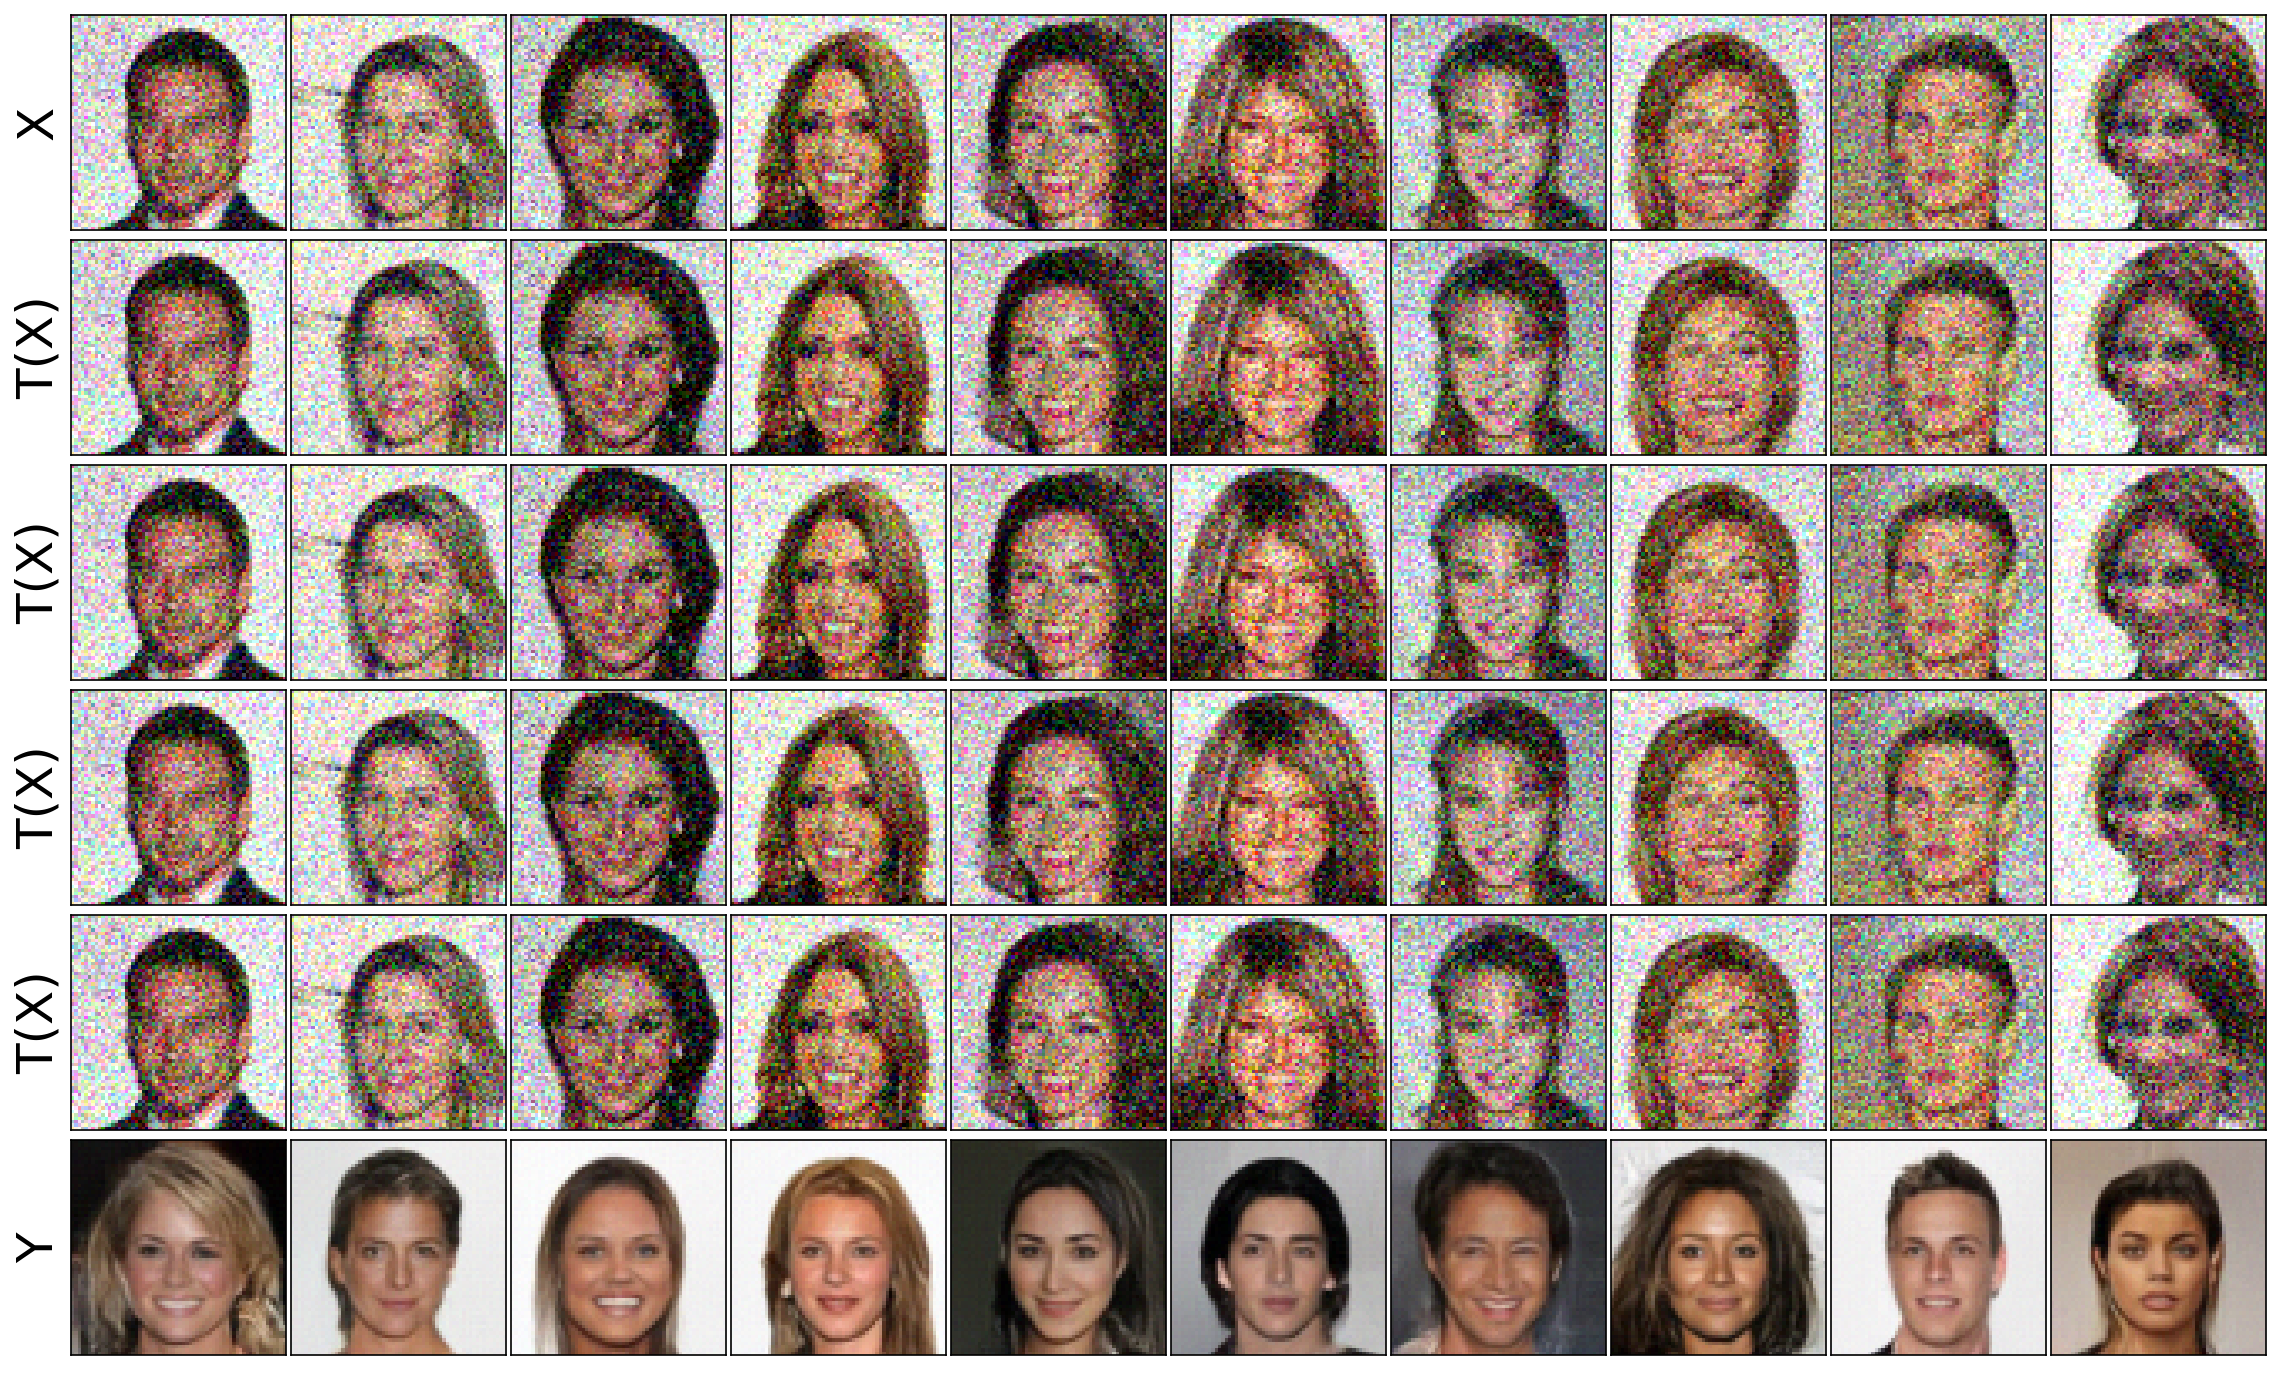

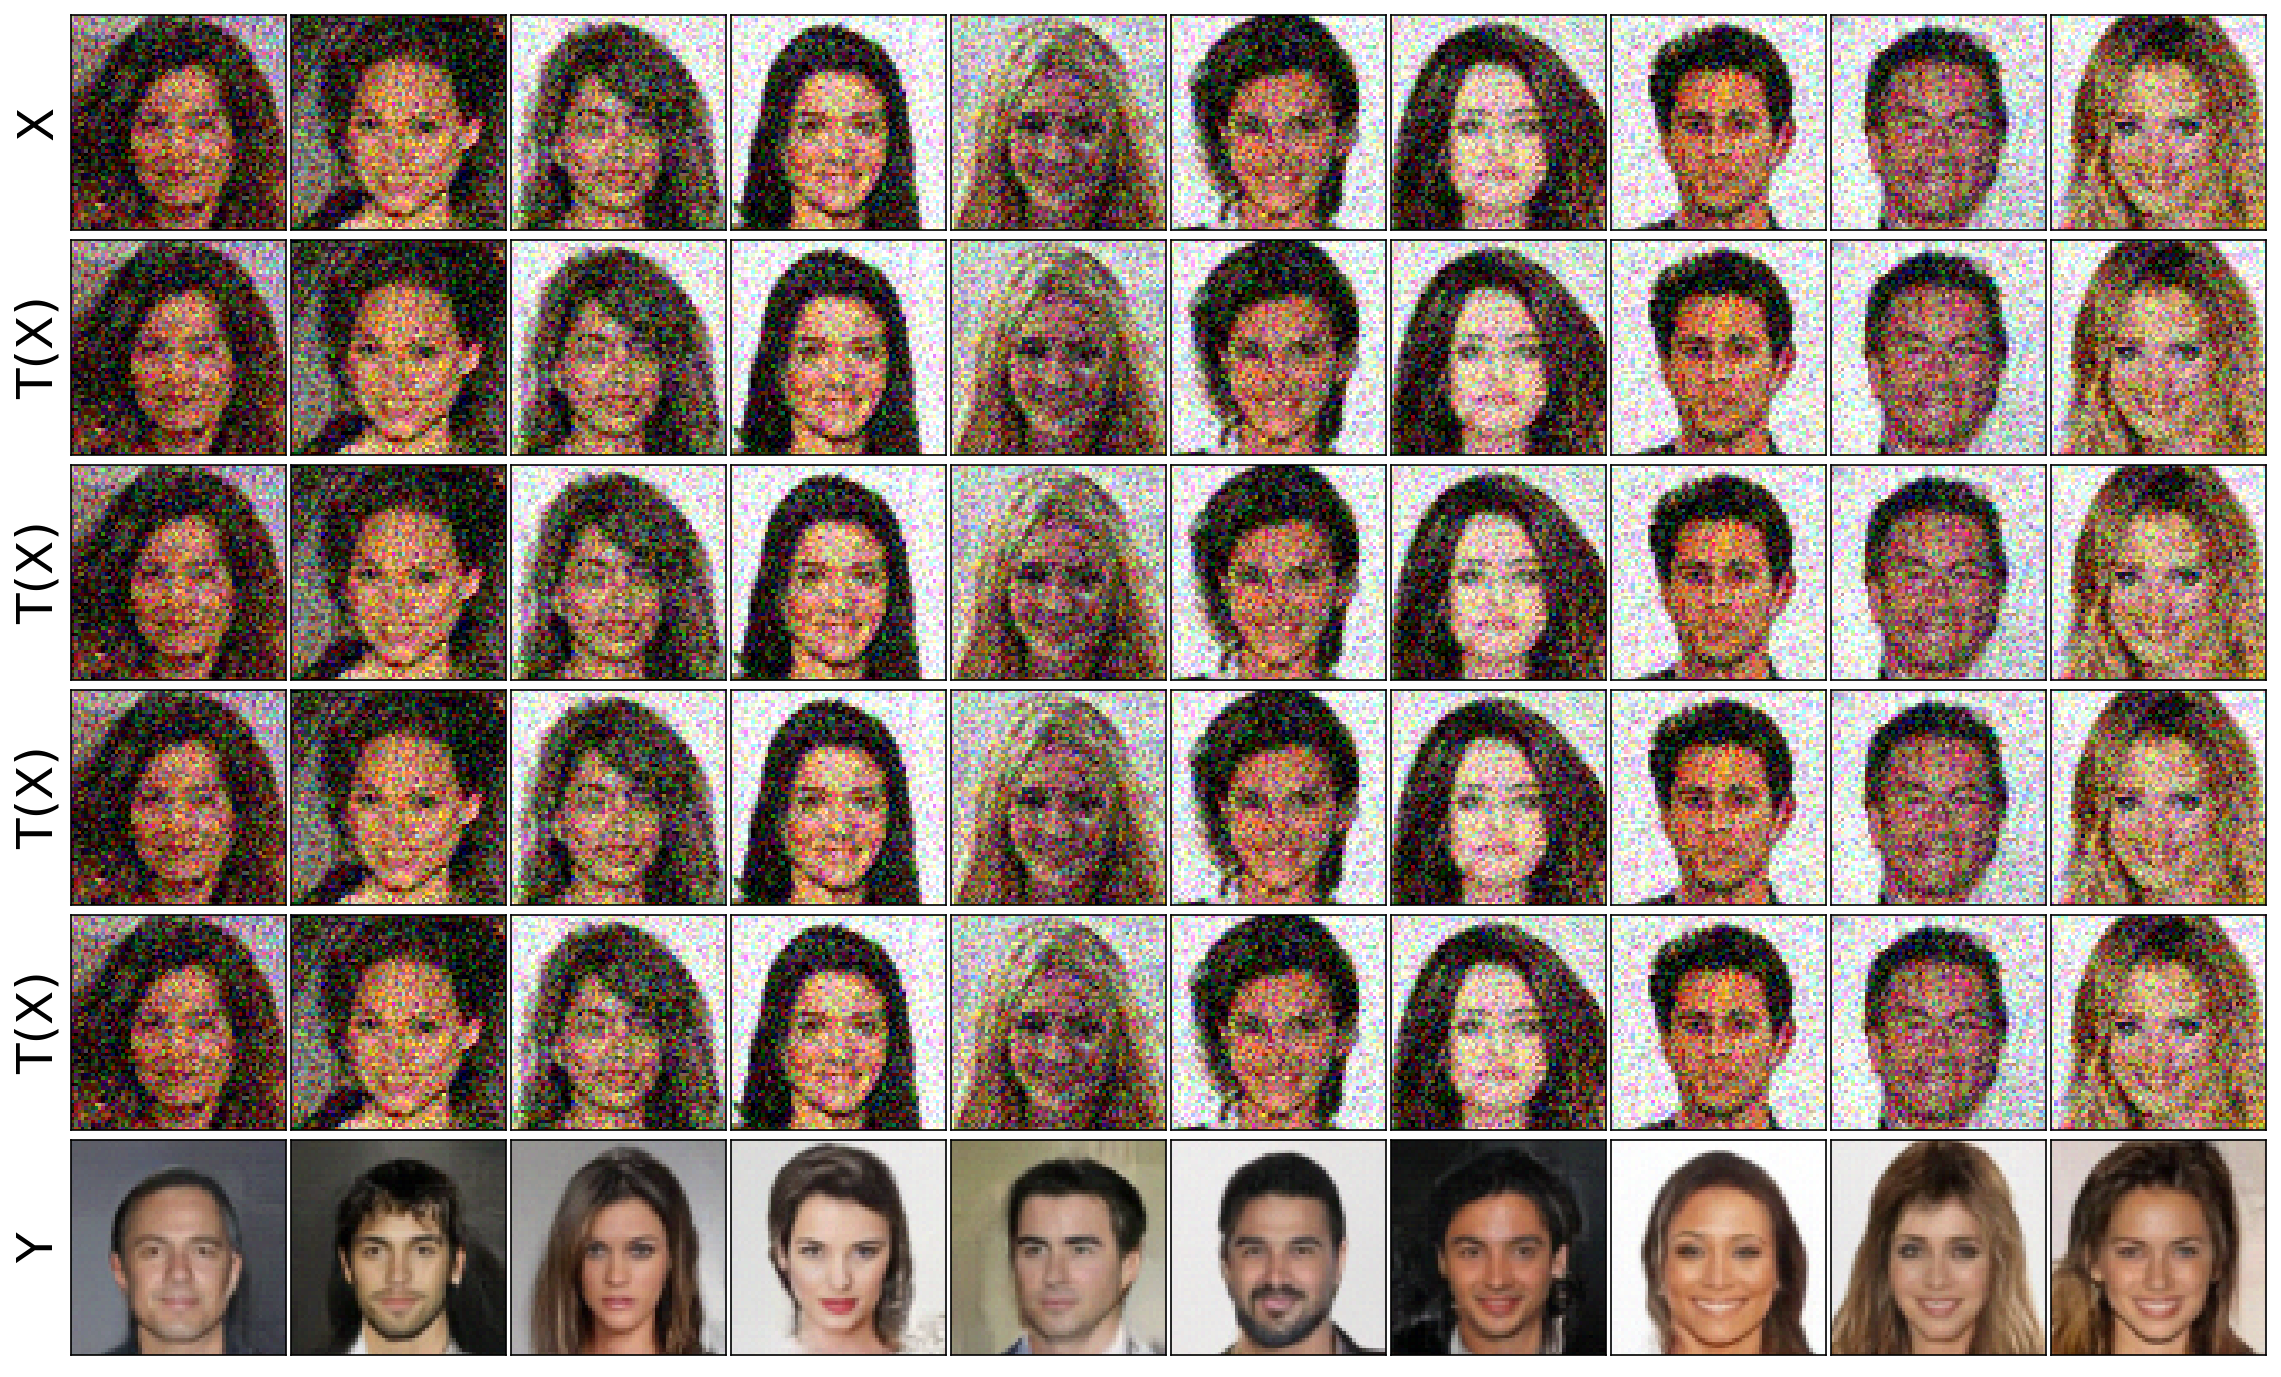

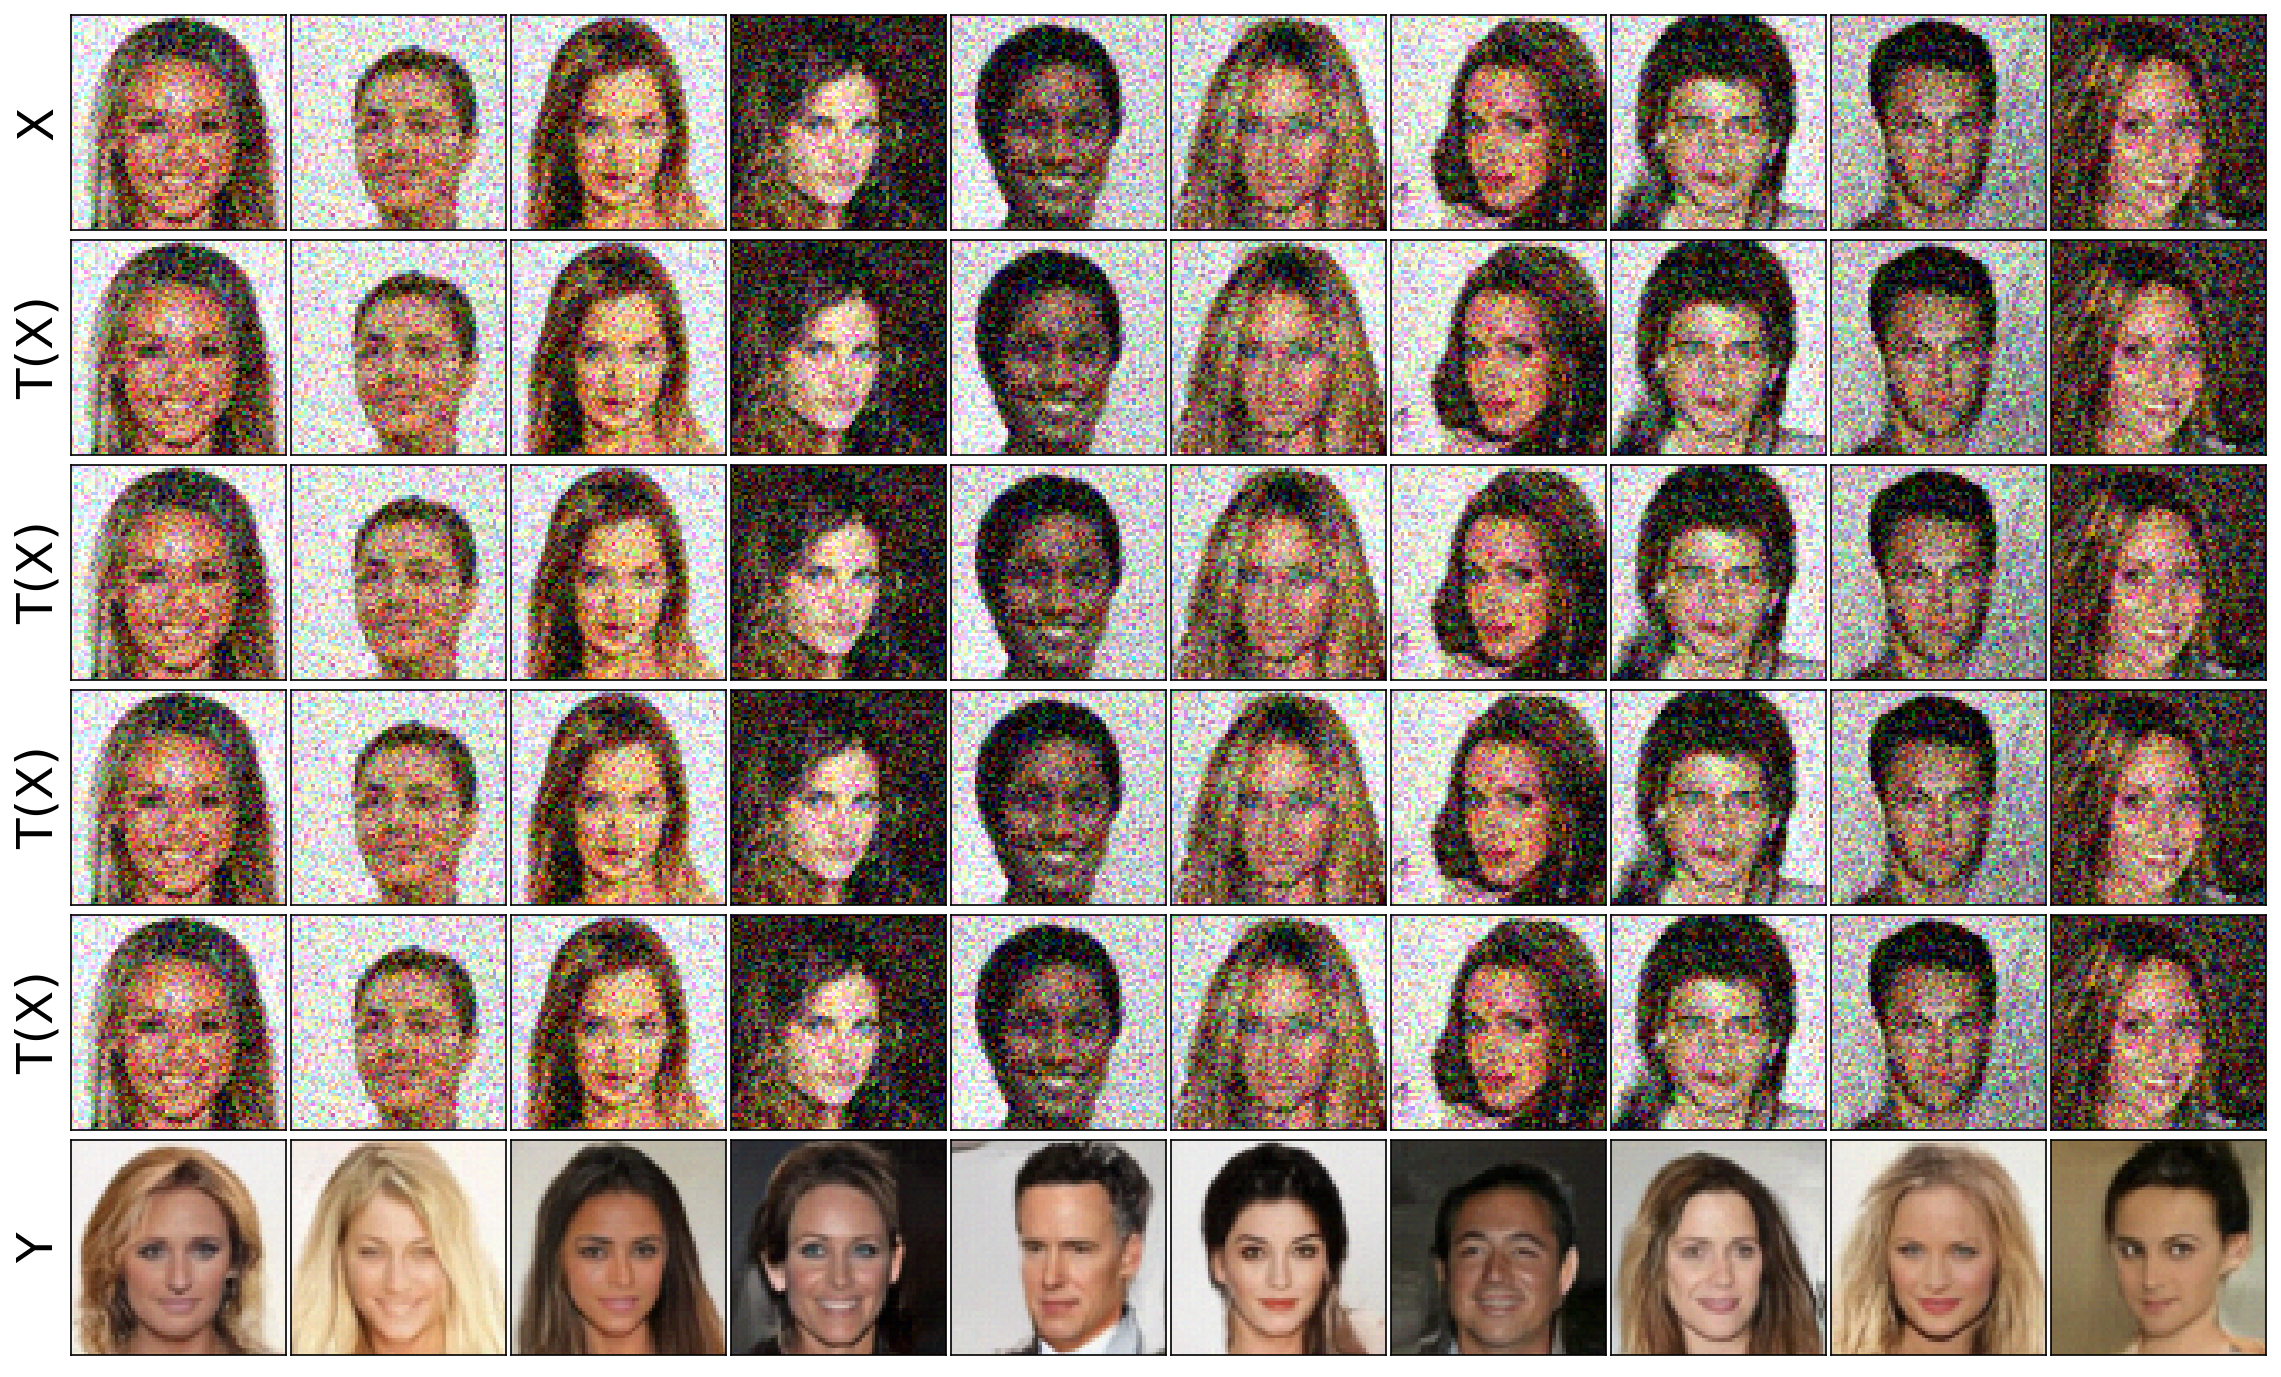

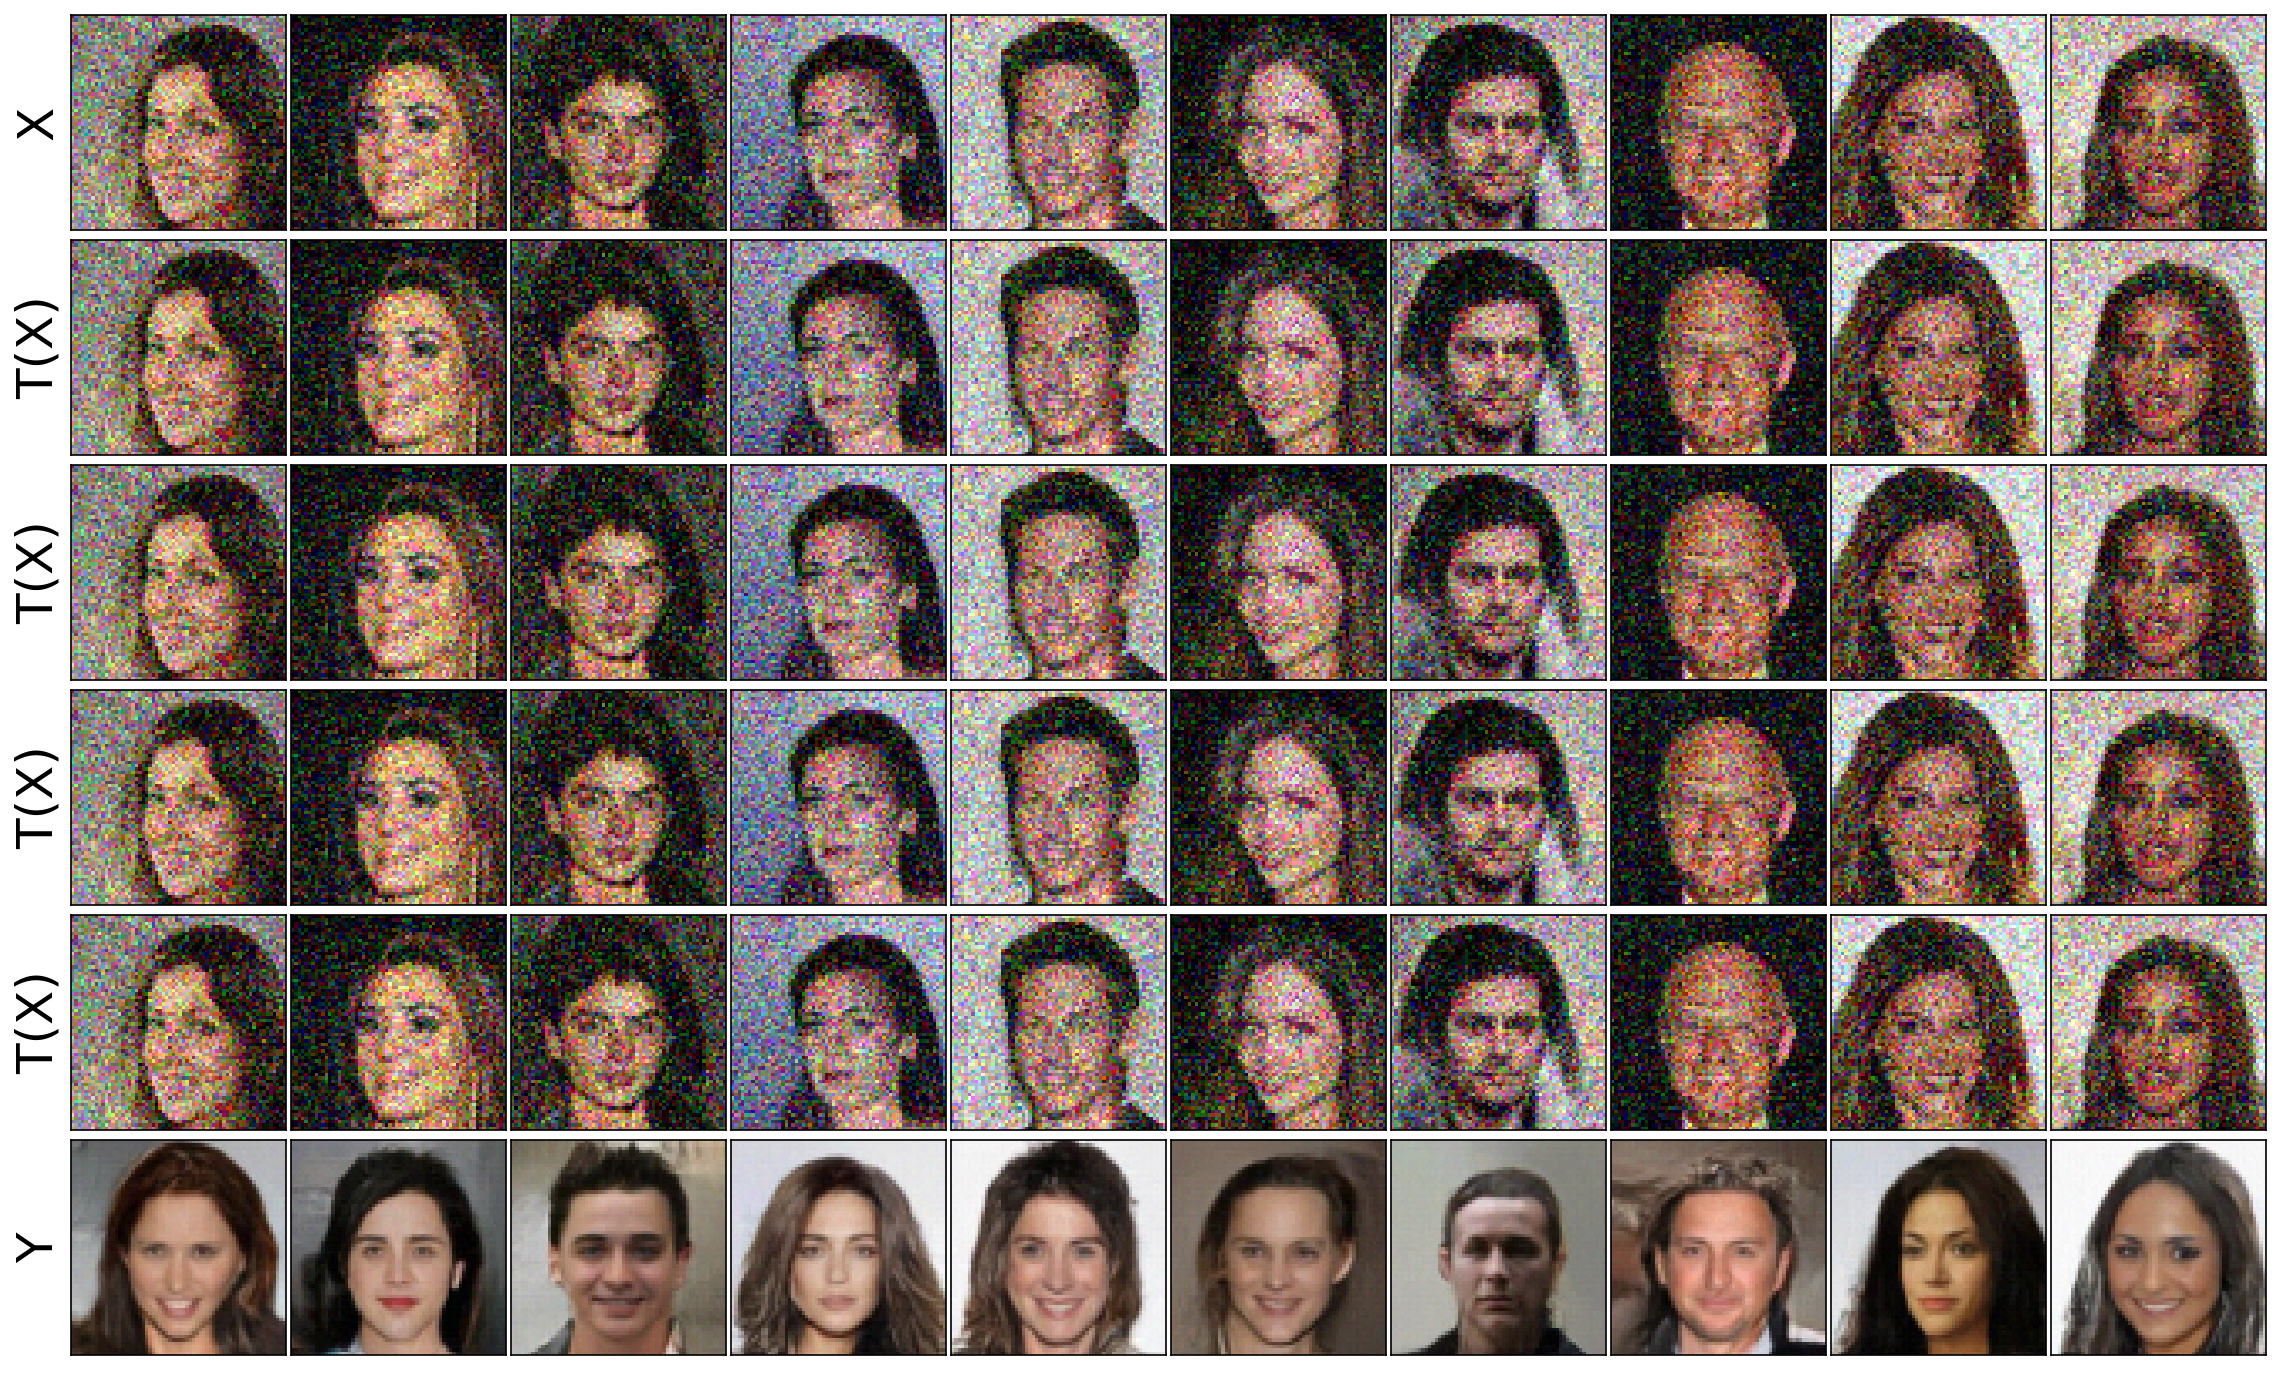

100%|█████████▉| 999/1000 [06:09<00:00,  6.01it/s]  

Computing FID


100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]


In [12]:
# metrics = []
torch.manual_seed(SEED); np.random.seed(SEED)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    model.train()
    
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_fixed_images(X_fixed, Y_fixed, model, gray=GRAY_PLOTS)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_random_images(X_sampler, Y_sampler, model, gray=GRAY_PLOTS)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_fixed_images(X_test_fixed, Y_test_fixed, model, gray=GRAY_PLOTS)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler,  Y_test_sampler, model, gray=GRAY_PLOTS)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step)
        plt.show(fig); plt.close(fig)
        
        
    if (step % CPKT_INTERVAL == CPKT_INTERVAL - 1) or step == 0:
        model.eval()
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(model, X_test_sampler.loader, n_epochs=FID_EPOCHS)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma
    
    gc.collect(); torch.cuda.empty_cache()